In [1]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import pandas as pd
import requests
import os.path as osp
import pickle
import random
import numpy as np
from pathlib import Path
import sys
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import shutil

c:\users\aphri\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def read_pickle(dir):
    with open(dir, 'rb') as handle:
        b = pickle.load(handle)
    return b


def write_pickle(dir, data):
    with open(dir, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

class Timer:
    def __init__(self):

        self.t1 = None

    @staticmethod
    def delta_to_string(td):

        res_list = []

        def format():
            return ", ".join(reversed(res_list)) + " elapsed."

        seconds = td % 60
        td //= 60
        res_list.append(f"{round(seconds,3)} seconds")

        if td <= 0:
            return format()

        minutes = td % 60
        td //= 60
        res_list.append(f"{minutes} minutes")

        if td <= 0:
            return format()

        hours = td % 24
        td //= 24
        res_list.append(f"{hours} hours")

        if td <= 0:
            return format()

        res_list.append(f"{td} days")

        return format()

    def __enter__(self):

        self.t1 = time.time()

    def __exit__(self, *args, **kwargs):

        t2 = time.time()
        td = t2 - self.t1

        print(self.delta_to_string(td))


def top_n(input_dict, n):
    return dict(sorted(input_dict.items(), key=itemgetter(1), reverse=True)[:n])


def find_products(text_input, category_df, title_df):

    text_input = [text_input]

    # stage one, compare categories
    category_df = category_df[~category_df["encoded_category"].isna()]
    categories = list(category_df["category"].values)

    categories_features = torch.stack(list(category_df["encoded_category"].values))
    encoded_texts = clip.tokenize(text_input).to(device)

    with torch.no_grad():

        text_features = model.encode_text(encoded_texts)

        categories_features /= categories_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity =  100 * categories_features @ text_features.T

    res = dict(zip(categories, similarity.reshape(-1).tolist()))

    res = sorted(res.items(), key=itemgetter(1), reverse=True)

    n = 100
    res_list = []
    res_count = 0
    for r in res:
        cur_res = meta_df[meta_df["combined_category"] == r[0]]
        res_list.append(cur_res)
        res_count += len(cur_res)
        if res_count >= n:
            break

    # stage two, compare titles
    res = pd.concat(res_list, axis=0)
    res = res.title.values

    title_df = title_df[title_df.title.isin(res)]
    titles = list(title_df["title"].values)

    title_features = torch.stack(list(title_df["encoded_title"].values))

    with torch.no_grad():

        title_features /= title_features.norm(dim=-1, keepdim=True)
        similarity =  100 * title_features @ text_features.T

    res = dict(zip(titles, similarity.reshape(-1).tolist()))
    
    res = sorted(res.items(), key=itemgetter(1), reverse=True)

    n = 5
    res = res[:n]
    res_set = set([r[0] for r in res])
    res = meta_df[meta_df["title"].isin(res_set)]["uniq_id"].values
    
    return res


def show_images(res):
    n = len(res)
    fig, ax = plt.subplots(1, n)

    fig.set_figheight(5)
    fig.set_figwidth(5 * n)
    
    iterable = True
    try:
       it = ax[0]
    except:
        iterable = False

    if not iterable:
        img_path = image_path(res[0])
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
    else:
        for i, image in enumerate(res):
            img_path = image_path(image)
            img = mpimg.imread(img_path)

            ax[i].imshow(img)
            ax[i].axis('off')
            # ax[i].set_title(get_label(image), fontsize=8)

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()
    
    
def image_path(uid):
    return osp.join(image_storage, f"{uid}.jpg")


def load_data(pickle_path):
    category_df = read_pickle(osp.join(pickle_path, "categories.pkl"))
    title_df = read_pickle(osp.join(pickle_path, "titles.pkl"))
    meta_df = read_pickle(osp.join(pickle_path, "meta_data.pkl"))
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    return device, model, preprocess, category_df, title_df, meta_df

In [3]:
image_storage = "demo_data/target_images"
pickle_path = "demo_data/pickle"

with Timer():
    (
        device,
        model, 
        preprocess,
        category_df,
        title_df,
        meta_df
    ) = load_data(pickle_path)

1.0 minutes, 25.946 seconds elapsed.


In [4]:
des_path = "demo_data/product_description.pkl"
dataset_path = "data/cleaned_target_furniture_dataset.csv"

if osp.exists(des_path):
    d1 = read_pickle(des_path)
else:
    d1 = pd.read_csv(dataset_path)
    d1 = d1[["uniq_id", "description", "sub_category_2", "colors"]]
    write_pickle(des_path, d1)

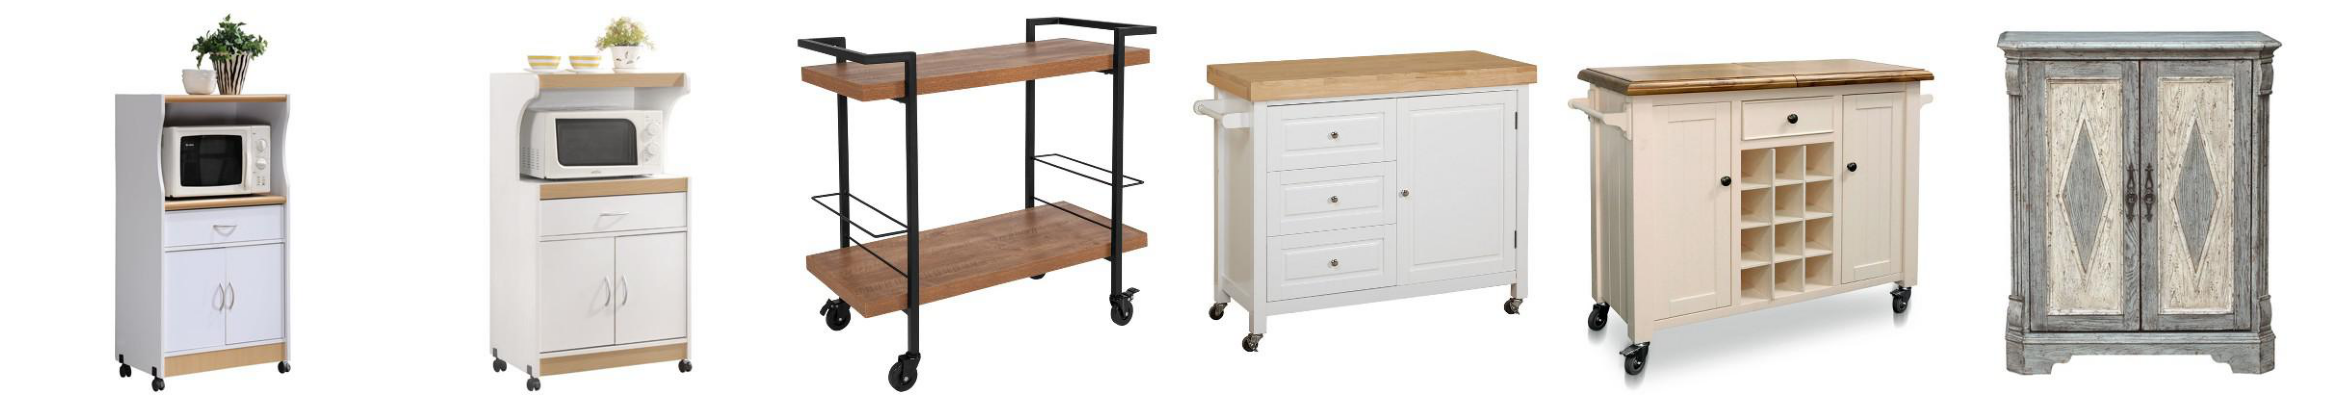

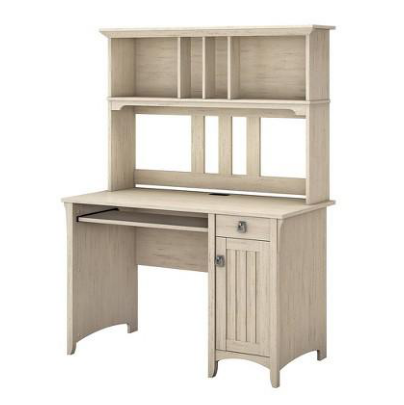

In [5]:
query = meta_df.loc[0]["title"]
answer = meta_df.loc[0]["uniq_id"]
res = find_products(query, category_df, title_df)
show_images(res)
show_images([answer])

In [6]:
def is_match(answer, res):
    s1 = {tuple(v) for v in d1[d1.uniq_id.isin([answer])][["sub_category_2", "colors"]].values}
    s2 = {tuple(v) for v in d1[d1.uniq_id.isin(res)][["sub_category_2", "colors"]].values}
    
    ans = len(s1.intersection(s2))
    return ans > 0

In [7]:
eval_path = "demo_data/eval_res1.pkl"

In [8]:
curr_total = 0
curr_right = 0
right_set = set()

if osp.exists(eval_path):
    res = read_pickle(eval_path)
    curr_total = res["total"]
    curr_right = res["right"]
    right_set = res["right_set"]

In [13]:
df1 = meta_df[:2500]
count = 0
for idx, row in df1.iterrows():
    
    count += 1
    if count < curr_total + 1:
        continue
    
    query = row["title"]
    answer = row["uniq_id"]
    res = find_products(query, category_df, title_df)
    curr_total += 1
    if is_match(answer, res):
        curr_right += 1
        right_set.add(answer)
    
    if curr_total % 200 == 0:
        print(f"{curr_total} current accuracy: {round(curr_right * 100/curr_total, 2)}%")

current accuracy: 49.42%


In [14]:
res = dict(
    total=curr_total,
    right=curr_right,
    right_set=right_set
)
write_pickle(eval_path, res)

In [15]:
round(res["right"] * 100 / res["total"], 2)

49.28

In [16]:
res["total"]

2500